# Project DSAIE: FLOOD1 CNN-Model
The main task of the neural network is to predict water depth in meters based on an unseen Digital Elevation Map (DEM).

The U-Net network is selected to model the water depth as it can work well with gridded data. The U-Net is based on a fully convolutional neural network. 


## Libraries

In [1]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
import time

from cycler import cycler
import seaborn as sns

# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

In [2]:
#Change this cell to have the local path to the correct folders

# go to FLOOD/CNN_model
 %cd ..
# go to FLOOD/_model/model
folder_path = 'Models'
%cd "$folder_path"
import CNN_UNet as unet

# go to FLOOD/CNN_model
%cd ..
# go to FLOOD/CNN_model/Data/Preprocessed_data
folder_path = 'Data/Preprocessed_data'
%cd "$folder_path"

## Training dataset and selection of test dataset

As a first step the datasets are loaded. The data is pre-processed before, so it can be downloaded directly.
In the cell below one test dataset should be selected for testing the performance of the model.
- test dataset 1: 20 DEM and WD with grid size of 64x64 km, time scale 4 days and starting point flood not changing
- test dataset 2: 20 DEM and WD with grid size of 64x64 km, time scale 4 days and starting point flood changing
- test dataset 3: 20 DEM and WD with grid size of 128x128 km, time scale 10 days and starting point flood changing

The training data consists of 80 DEM locations and corresponding waterdepth (WD).

It is important to mention that in order to be able to test dataset 3, the dataset is cut off to the first 4 days (instead of 10 days).


In [3]:
train_dataset = torch.load('train_dataset_CNN_time_three_inputs.pt')

#select the test dataset
dataset = 1

test_dataset = torch.load('test_dataset_1_CNN_time_three_inputs.pt')
#test_dataset = torch.load('test_dataset_2_CNN_time_three_inputs.pt')
#test_dataset = torch.load('test_dataset_3_CNN_time_three_inputs.pt')

### Plot the inputs and outputs for one example.

The inputs and outputs are as follows:

Inputs:
- digital elevation model (DEM)
- Water depth (WD) for the first time step

Output:
- Water depth for each time step

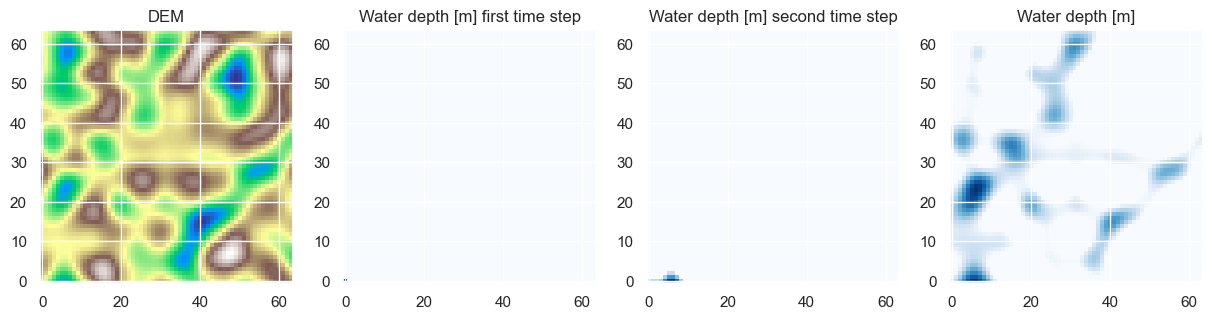

In [4]:
inputs, outputs = train_dataset[0]
fig, axs = plt.subplots(1, 4, figsize=(15, 7))

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='Blues', origin='lower')
axs[1].set_title('Water depth [m] first time step')

axs[2].imshow(inputs[2].cpu(), cmap='Blues', origin='lower')
axs[2].set_title('Water depth [m] second time step')

axs[3].imshow(outputs[-1].cpu(), cmap='Blues', origin='lower')
axs[3].set_title('Water depth [m]')

plt.show()

### Normalization

Since the input and output values may have very different ranges, it is important to perform normalization to both.

In [5]:
def normalize_dataset(dataset, scaler_x, scaler_y):
    min_x, max_x = scaler_x.data_min_[0], scaler_x.data_max_[0]
    min_y, max_y = scaler_y.data_min_[0], scaler_y.data_max_[0]
    normalized_dataset = []
    for idx in range(len(dataset)):
        x = dataset[idx][0]
        y = dataset[idx][1]
        norm_x = (x - min_x) / (max_x - min_x)
        norm_y = (y - min_y) / (max_y - min_y)
        normalized_dataset.append((norm_x, norm_y))
    return normalized_dataset

In [6]:
# Normalize the inputs and outputs using training dataset
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

for idx in range(len(train_dataset)):
    scaler_x.partial_fit(train_dataset[idx][0].reshape(inputs.shape[0], -1).T.cpu())
    scaler_y.partial_fit(train_dataset[idx][1].reshape(-1, 1).cpu())

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_y)
normalized_test_dataset = normalize_dataset(test_dataset, scaler_x, scaler_y)

The training data is splitted in a training and validation part. The model is trained on the training data (80%) and overfitting is prevented by using validation data (20%). Every time the code is runned, a different split between validation and training data is made.

In [7]:
# Split dataset into train, validation
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size]) #different split for each run

# Model

The U-Net network is selected to model the water depth as it can work well with gridded data. The U-Net is based on a fully convolutional neural network. To speed up the running time, the model should be runned on a GPU.

The network has an encoder and decoder part. In this encoder part the spatial information is reduced while the feature information is increased. The double convolution consists of twice a 2D convolution followed by batch normalization, a ReLU activation function and a max pooling operation for downsampling the spatial dimension. The batch normalization normalizes the input of each layer within a mini-batch, to address for variance explosion.
A choice was made to use ReLU6 as an activation function. ReLU6 limits the output to a maximum size of 6. This means that any input below 0 will be removed, while any input above 6 is converted to 6. ReLU6 improves the robustness of low-precision computation. The model performed better when using ReLU6 compared to ReLU.
After this step the data downsampled using 5 max pooling layers. In this encoder the spatial information is reduced while the feature information is increased.

The decoder consists of a sequence of up-convolutions. The data upsampled 5 times and goes trough the double convlution function every time to reduce the number of channels.

Input in the U-Net network:
- Series with DEMs
- corresponding first time waterdpeth (WD)

Targets:
- Waterdepths at 96 timesteps(97 - first time step), correspinding to 4 days if 30-minute measurements.

The model is based on one step forecast, where all targets are predicted in one go. There are two input channels in the network as there are two inputs and 96 classes as there are 96 timesteps to predict per DEM (targets).
The  number of input and output channels per layer is defined by calibrating the network to find the optimal values.




In [8]:
model = unet.UNet(n_channels = 3, n_classes = 95)

# Training


The model is trained with the 'train_epoch' function below. The losses are computed with the mean squared error (MSE) with the prediction data and targets. The loss is minimized by optimizing the weights in the network. The evaluation function is used to compute the losses for the validation data. The losses are computed the same way as in training. However, the weights are not optimized in validation.

In [9]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0]
        y = batch[1]

        # Model prediction
        preds = model(x)

        # MSE loss function
        loss = nn.MSELoss()(preds, y)

        losses.append(loss.cpu().detach())

        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [10]:
def evaluation(model, loader, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    losses = []

    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            y = batch[1]

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

### Define the training paramters, the optimizer, and the dataloader

The three hyperparameters (learning rate, batch size and number of epochs) are calibrated by hand. The values below resulted in the best performance of the model.

In [11]:
# Set training parameters
learning_rate = 0.001 #proven to be best value
batch_size = 8
num_epochs = 300

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

## Training and validating

The next step is to train the U-Net model for a number of epochs.
During training the model with the training and validation data, both the training and test losses are recorded. To compare the models based on runtimes the 'start_time' and 'end_time' variables are added, which calculates the run time of the training part.
For each epoch the 'train_epoch' function is used, which returns the train_loss. The evaluation function calculates the validation loss for each epoch.
If for an epoch the validation loss is lower than the 'best_loss' so far, the 'best_loss' is updated. In the 'best_epoch' the best epoch number is saved.
If the best_loss does not change for more then 25 epoch the model is stopped (early stopping).

In [13]:
# Lists to store losses and accuracies
training_losses = []
validation_losses = []

# Keep track of the best validation accuracy and save the best model
best_loss = np.inf #set to infinity to make sure the loss of the first epoch is saved
best_model_path = 'best_model.pth'

# Parameter to calculate the runtime of the model
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    training_losses.append(train_loss)
    validation_loss = evaluation(model, val_loader)
    validation_losses.append(validation_loss)

    if best_loss > validation_loss:
        print(f'Lowest loss updated at epoch {epoch}: {validation_loss:.5f}')
        best_loss = validation_loss
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)

    if epoch - best_epoch > 25: #stop if the validation loss has not improved for more than 25 epochs
        break

  # print all losses every fifth epoch
    if epoch%5 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,5), # we print loss and not accuracy
                              "\t validation loss:", np.round(validation_loss,5),
                              "\t best loss:", np.round(best_loss, 5))

# Check the run time of the model
end_time = time.time()
run_time = end_time - start_time

Lowest loss updated at epoch 0: 0.03115
epoch: 0 	 training loss: 0.10241 	 validation loss: 0.03115 	 best loss: 0.03115
Lowest loss updated at epoch 1: 0.02977
Lowest loss updated at epoch 2: 0.02498
Lowest loss updated at epoch 3: 0.01998
Lowest loss updated at epoch 4: 0.01669
Lowest loss updated at epoch 5: 0.01455
epoch: 5 	 training loss: 0.01554 	 validation loss: 0.01455 	 best loss: 0.01455
Lowest loss updated at epoch 6: 0.01284
Lowest loss updated at epoch 7: 0.01154
Lowest loss updated at epoch 8: 0.01043
Lowest loss updated at epoch 9: 0.00954
Lowest loss updated at epoch 10: 0.00882
epoch: 10 	 training loss: 0.00899 	 validation loss: 0.00882 	 best loss: 0.00882
Lowest loss updated at epoch 11: 0.00823
Lowest loss updated at epoch 12: 0.00781
Lowest loss updated at epoch 13: 0.00735
Lowest loss updated at epoch 14: 0.00700
Lowest loss updated at epoch 15: 0.00668
epoch: 15 	 training loss: 0.00661 	 validation loss: 0.00668 	 best loss: 0.00668
Lowest loss updated at e

In [14]:
# Load the best model after training is complete
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [15]:
#Denormalize and compute the test loss
loss_function = nn.MSELoss()
test_loss = []
for i in normalized_test_dataset:
    test_output = model(i[0].unsqueeze(0)).detach()
    #output_size = test_output.shape[-1]
    denormalized_test_output = scaler_y.inverse_transform(test_output.reshape(-1,1).cpu()).T
    denormalized_data = scaler_y.inverse_transform(i[1].reshape(-1,1).cpu()).T
    test_loss.append(loss_function(torch.Tensor(denormalized_test_output[0]), torch.Tensor(denormalized_data[0])))

test_los_denorm = np.array(test_loss).mean()
print(test_los_denorm)

0.027478397


In [16]:
#general performance of the model
print(f'runtime in seconds: {run_time:.2f}')
print(f'validation loss last epoch: {validation_losses[-1]:.5f}')

runtime in seconds: 284.64
validation loss last epoch: 0.00144


# Visualize results

In this part the performance of the trained model are visualized. First the training and validation losses are shown in a figure. From this it can become clear if both losses are descreasing over the epochs.

## Losses



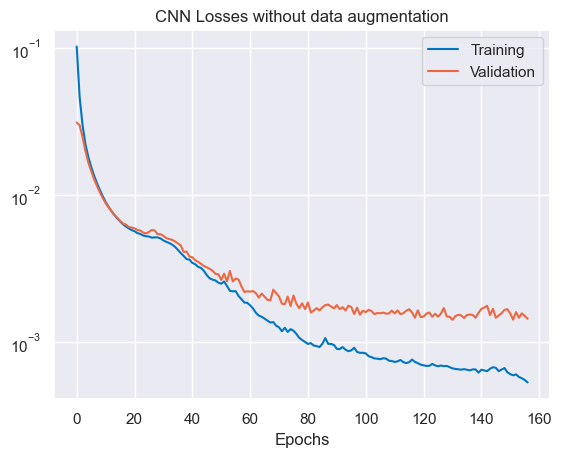

In [17]:
plt.plot(training_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('CNN Losses without data augmentation')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Visualize the test dataset predictions

To have a visual idea of the quality of the predictions for the test dataset a random id of the test dataset is selected and visualized for three timesteps.


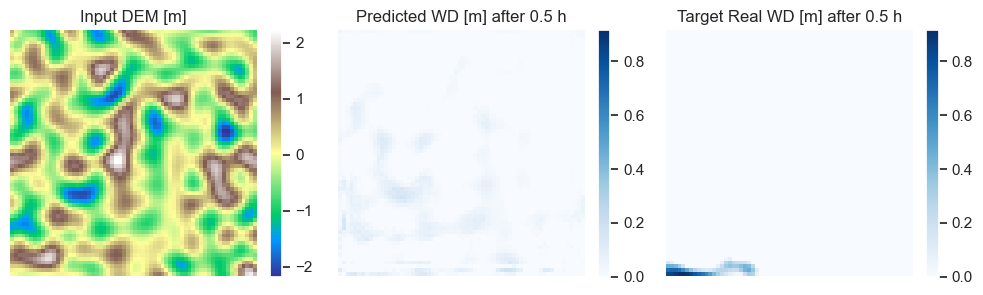

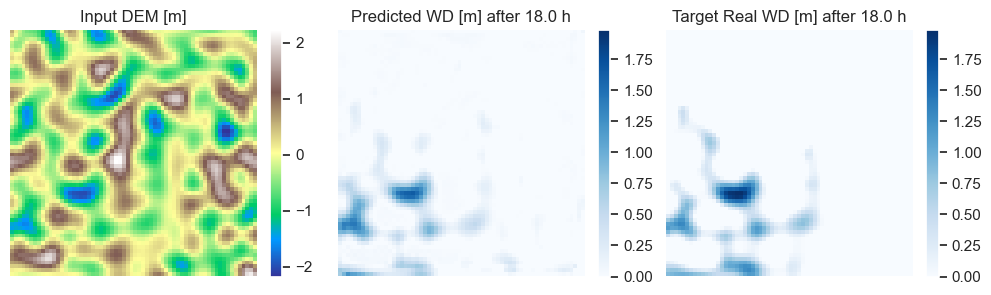

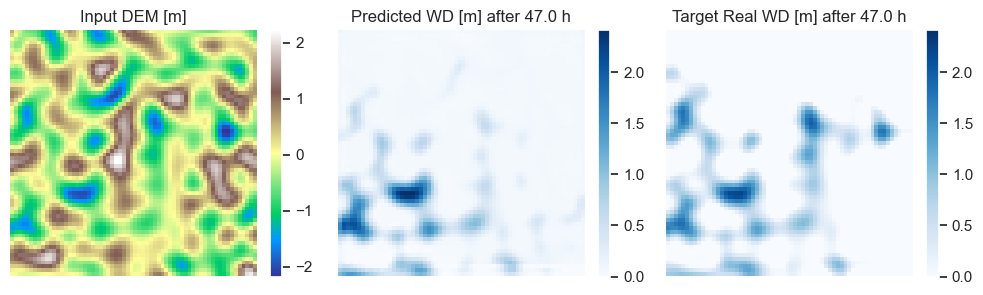

In [20]:
#visualize 3 timesteps
time_step = [1, 36, 94] #Just for visualization three time_steps are selected to have an idea of the developed over time

for i in time_step:
    data_id = 4 #random number of one of the test dataset id
    x = normalized_test_dataset[data_id][0].unsqueeze(0)
    WD = normalized_test_dataset[data_id][1]
    pred_WD = model(x).detach()

    if dataset == 3: #different reshape values
        DEM = scaler_x.inverse_transform(x[0].reshape(3,-1).T.cpu())[:,0].reshape(128,128)
        real_WD = scaler_y.inverse_transform(WD[i].reshape(-1,1).cpu()).reshape(128,128)
        pred_WD = scaler_y.inverse_transform(pred_WD[0][i].reshape(-1,1).cpu()).reshape(128,128)
    else:
        DEM = scaler_x.inverse_transform(x[0].reshape(3,-1).T.cpu())[:,0].reshape(64,64)
        real_WD = scaler_y.inverse_transform(WD[i].reshape(-1,1).cpu()).reshape(64,64)
        pred_WD = scaler_y.inverse_transform(pred_WD[0][i].reshape(-1,1).cpu()).reshape(64,64)

    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    max_WD = max(pred_WD.max(), real_WD.max())
    axs[0].imshow(DEM.squeeze(), cmap='terrain', origin='lower')
    axs[2].imshow(real_WD.squeeze(), vmin = 0, vmax=max_WD, cmap='Blues', origin='lower')
    axs[1].imshow(pred_WD.squeeze(), vmin = 0, vmax=max_WD,cmap='Blues', origin='lower')

    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = DEM.min(), vmax=DEM.max()),
                              cmap='terrain'), fraction=0.05, shrink=0.8, ax=axs[0])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_WD),
                              cmap='Blues'), fraction=0.05, shrink=0.8, ax=axs[1])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_WD),
                              cmap='Blues'), fraction=0.05, shrink=0.8, ax=axs[2])

    for ax in axs:
        ax.axis('off')
    axs[0].set_title('Input DEM [m]')
    axs[2].set_title(f'Target Real WD [m] after {(i / 2)} h')
    axs[1].set_title(f'Predicted WD [m] after {(i / 2)} h')

    plt.show()

In [24]:
#make video

images = []
import imageio

time_step = np.arange(1, 95, 1) #Just for visualization three time_steps are selected to have an idea of the developed over time

for i in time_step:
    data_id = 4 #random number of one of the test dataset id
    x = normalized_test_dataset[data_id][0].unsqueeze(0)
    WD = normalized_test_dataset[data_id][1]
    pred_WD = model(x).detach()

    if dataset == 3: #different reshape values
        DEM = scaler_x.inverse_transform(x[0].reshape(3,-1).T.cpu())[:,0].reshape(128,128)
        real_WD = scaler_y.inverse_transform(WD[i].reshape(-1,1).cpu()).reshape(128,128)
        pred_WD = scaler_y.inverse_transform(pred_WD[0][i].reshape(-1,1).cpu()).reshape(128,128)
    else:
        DEM = scaler_x.inverse_transform(x[0].reshape(3,-1).T.cpu())[:,0].reshape(64,64)
        real_WD = scaler_y.inverse_transform(WD[i].reshape(-1,1).cpu()).reshape(64,64)
        pred_WD = scaler_y.inverse_transform(pred_WD[0][i].reshape(-1,1).cpu()).reshape(64,64)

    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    max_WD = max(pred_WD.max(), real_WD.max())
    axs[0].imshow(DEM.squeeze(), cmap='terrain', origin='lower')
    axs[2].imshow(real_WD.squeeze(), vmin = 0, vmax=max_WD, cmap='Blues', origin='lower')
    axs[1].imshow(pred_WD.squeeze(), vmin = 0, vmax=max_WD,cmap='Blues', origin='lower')

    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = DEM.min(), vmax=DEM.max()),
                                    cmap='terrain'), fraction=0.05, shrink=0.8, ax=axs[0])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=2),
                                    cmap='Blues'), fraction=0.05, shrink=0.8, ax=axs[1])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=2),
                                    cmap='Blues'), fraction=0.05, shrink=0.8, ax=axs[2])

    for ax in axs:
        ax.axis('off')
    fig.suptitle(f'Predictions for dataset1[4] at Timestep {(i / 2) + 0.5} hours')
    axs[0].set_title('DEM')
    axs[1].set_title(f'Predicted WaterDepth [m]')
    axs[2].set_title(f'Original WaterDepth [m]')

    #plt.show()
    
    plt.savefig(f'Images/{i}.png', bbox_inches='tight', dpi=150, pad_inches=0)
    images.append(imageio.v2.imread(f'Images/{i}.png'))

    plt.close(fig)
    
imageio.mimsave('dataset1_4.gif', images, duration = 0.1)

To include all datasets in the testset the figure below shows the loss for each testing set. From this the range of test losses is visualized.

In [22]:
model.eval()

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        x = batch[0]
        y = batch[1]

        # Model prediction
        preds = model(x)
        all_preds.append(preds)

# concatenate all predictions
all_preds = torch.cat(all_preds, dim=0)

# select all outputs from test dataset
test_WD = torch.stack([normalized_test_dataset[i][1] for i in range(len(normalized_test_dataset))])

# loss on the test dataset per sample
test_loss = torch.stack([nn.MSELoss()(all_preds[i], test_WD[i]) for i in range(len(all_preds))])

In [ ]:
plt.plot(test_loss.cpu())
plt.title('Test loss per sample')
plt.xlabel('Sample id');

In [ ]:
#Values of the test loss from the graph above
print(f'Minimum test loss: {test_loss.min():.5f} and maximum test loss: {test_loss.max():.5f}')

### Visualize training data

As an extra check of the quality of the model two training DEM's are shown with their corresponding target en predicted WD map. Based on this it can be visualy inspected if the model training performs well.

In [ ]:
time_step = 95 #Visualizing only the last time step

data_id = [1, 4] #two random sample id are selected

for i in data_id:
    x = normalized_train_dataset[i][0].unsqueeze(0)
    WD = normalized_train_dataset[i][1]
    pred_WD = model(x).detach()

    DEM = scaler_x.inverse_transform(x[0].reshape(3,-1).T.cpu())[:,0].reshape(64,64)
    real_WD = scaler_y.inverse_transform(WD[time_step].reshape(-1,1).cpu()).reshape(64,64)
    pred_WD = scaler_y.inverse_transform(pred_WD[0][time_step].reshape(-1,1).cpu()).reshape(64,64)

    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    max_WD = max(pred_WD.max(), real_WD.max())

    axs[0].imshow(DEM.squeeze(), cmap='terrain', origin='lower')
    axs[1].imshow(real_WD.squeeze(), vmin = 0, vmax=max_WD, cmap='Blues', origin='lower')
    axs[2].imshow(pred_WD.squeeze(), vmin = 0, vmax=max_WD,cmap='Blues', origin='lower')

    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = DEM.min(), vmax=DEM.max()),
                              cmap='terrain'), fraction=0.05, shrink=0.9, ax=axs[0])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_WD),
                              cmap='Blues'), fraction=0.05, shrink=0.9, ax=axs[1])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_WD),
                              cmap='Blues'), fraction=0.05, shrink=0.9, ax=axs[2])

    for ax in axs:
        ax.axis('off')

    print(f'MAP show training data for data_id {i}')
    axs[0].set_title('DEM')
    axs[1].set_title(f'Real WD (m) after {(time_step / 2) + 0.5} h')
    axs[2].set_title(f'Predicted WD (m) after {(time_step / 2) + 0.5} h')

    plt.show()